In [2]:
# Import libraries
import os
import xarray as xr
# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()
# Disable xarray runtime warnings
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
import pandas as pd
import numpy as np
from lmoments3 import distr
from scipy.stats import gumbel_r, kstest
from tqdm import tqdm
import math
import random

#### Prepare GLOFAS data

In [3]:
DATADIR = r"D:\projects\sovereign-risk\Thailand\data\flood\dependence\glofas"

# Download data for Thaiand (the GIRI model uses the historical time period 1979-2016). We will pull data from 1979-2023
start_year = 1979
end_year = 2023

def combine_datasets(start, end, dir):
    '''
    combine all datasets into one xarray for analysis
    '''
    all_files = [os.path.join(dir, f"glofas_THA_{year}.grib") for year in range(start, end+1)]
    # Load all datasets into array
    datasets = [xr.open_dataset(file, engine='cfgrib') for file in all_files]
    # Concatenate all datasets along the time dimension
    combined_dataset = xr.concat(datasets, dim='time')
    # Make sure datasets are sorted by time
    combined_dataset = combined_dataset.sortby('time')
    
    return combined_dataset

# Load glofas data and combine
glofas_data = combine_datasets(start_year, end_year, DATADIR)

# Reduce the Upstream area data to the domain of the river discharge
upstream_area_fname = f"uparea_glofas_v4_0.nc"
upstream_area_file = os.path.join(DATADIR, upstream_area_fname)
# Filter glofas timeseries based on upstream accumulating area
area_filter = 500
upstream_area = xr.open_dataset(upstream_area_file, engine='netcdf4')

# Get the latitude and longitude limits of the data
lat_limits = [glofas_data.latitude.values[i] for i in [0, -1]]
lon_limits = [glofas_data.longitude.values[i] for i in [0, -1]]
up_lats = upstream_area.latitude.values.tolist()
up_lons = upstream_area.longitude.values.tolist()

lat_slice_index = [
    round((i-up_lats[0])/(up_lats[1]-up_lats[0]))
    for i in lat_limits
]
lon_slice_index = [
    round((i-up_lons[0])/(up_lons[1]-up_lons[0]))
    for i in lon_limits
]

# Slice upstream area to Thailand region:
red_upstream_area = upstream_area.isel(
    latitude=slice(lat_slice_index[0], lat_slice_index[1]+1),
    longitude=slice(lon_slice_index[0], lon_slice_index[1]+1),
)

# There are very minor rounding differences, so we update with the lat/lons from the glofas data
red_upstream_area = red_upstream_area.assign_coords({
    'latitude': glofas_data.latitude,
    'longitude': glofas_data.longitude,
})

# Add the upstream area to the main data object and print the updated glofas data object:
glofas_data['uparea'] = red_upstream_area['uparea']
glofas_data

# Mask the river discharge data
glofas_data_masked = glofas_data.where(glofas_data.uparea>=area_filter*1e6)

# Load the basin outlet data
basin_outlet_file = r"D:\projects\sovereign-risk\Thailand\data\flood\dependence\thailand-basins\lev06_outlets_final_clipped_Thailand_no_duplicates.csv"
basin_outlet_df = pd.read_csv(basin_outlet_file)
# Note to align the two datasets we need to make the following adjustment to lat lons (based on previous trial and error)
basin_outlet_df['Latitude'] = basin_outlet_df['Latitude'] + 0.05/2
basin_outlet_df['Longitude'] = basin_outlet_df['Longitude'] - 0.05/2

# Define function for checking timeseries
def check_timeseries(array, latitude, longitude):
    test_point = array.sel(latitude=latitude, longitude=longitude, method='nearest')
    test_timeseries = test_point['dis24']
    test_acc = float(test_point['uparea'])
    # check for NaN values
    non_nan_count = test_timeseries.count().item()
    total_count = test_timeseries.size
    nan_ratio = non_nan_count/total_count

    # Does the timeseries pass the NaN threshold
    if nan_ratio < 1:
        return False, test_acc, "NaN values found"

    # Check for constant values
    if test_timeseries.min() == test_timeseries.max():
        return False, test_acc, "Constant timeseries values"

    # If all checks pass
    return True, test_acc, "Valid timeseries"

# Loop through basins and check whether timeseries is valid
results = []
for index, row in basin_outlet_df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']

    valid, acc, message = check_timeseries(glofas_data_masked, latitude, longitude)

    # Store the results
    results.append({
        'HYBAS_ID': row['HYBAS_ID'],
        'Latitude': latitude,
        'Longitude': longitude,
        'Acc': acc,
        'Valid': valid,
        'Message': message
    })
    if not valid:
        print(f"ID: {row['HYBAS_ID']}, Lat: {latitude}, Lon: {longitude}, Acc: {acc}, Valid: {valid}, Message: {message}")

# over what years do we want to extract the data?
start_year = 1979
end_year = 2016
sliced_data = glofas_data_masked.sel(time=slice(str(start_year), str(end_year)))
# Dictionary to store timeseries data for each basin
basin_timeseries = {}

# Loop through basin outlets, storing each in turn
for index, row in basin_outlet_df.iterrows():
    basin_id = row['HYBAS_ID']
    lat = row['Latitude']
    lon = row['Longitude']
    point_data = sliced_data.sel(latitude=lat, longitude=lon, method='nearest')
    timeseries = point_data['dis24'].to_series()
    # store in dictionary
    basin_timeseries[basin_id] = timeseries

#### Perform EVA

In [4]:
# Dictionary to store fitted parameters for each basin
gumbel_params = {}
fit_quality = {}

# Loop through basins, calculating annual maxima and fitting Gumbel distribution using L-moments
for basin_id, timeseries in basin_timeseries.items():
    annual_maxima = timeseries.groupby(timeseries.index.year).max()

    # Fit Gumbel distribution using L-moments
    params = distr.gum.lmom_fit(annual_maxima)

    # Perform the Kolmogorov-Smirnov test (checking quality of fit)
    D, p_value = kstest(annual_maxima, 'gumbel_r', args=(params['loc'], params['scale']))

    gumbel_params[basin_id] = params
    fit_quality[basin_id] = (D, p_value)

# Will do this using the CDF of the fitted Gumbel distribution 

# Dictionary to story uniform marginals for each basin
uniform_marginals = {}

for basin_id, timeseries in basin_timeseries.items():
    annual_maxima = timeseries.groupby(timeseries.index.year).max()
    params = gumbel_params[basin_id]
    uniform_marginals[basin_id] = gumbel_r.cdf(annual_maxima, loc=params['loc'], scale=params['scale'])

basin_ids = list(uniform_marginals.keys())

# Dictionary to store fitted parameters for each basin
gumbel_params = {}
fit_quality = {}

# Loop through basins, calculating annual maxima and fitting Gumbel distribution using L-moments
for basin_id, timeseries in basin_timeseries.items():
    annual_maxima = timeseries.groupby(timeseries.index.year).max()

    # Fit Gumbel distribution using L-moments
    params = distr.gum.lmom_fit(annual_maxima)

    # Perform the Kolmogorov-Smirnov test (checking quality of fit)
    D, p_value = kstest(annual_maxima, 'gumbel_r', args=(params['loc'], params['scale']))

    gumbel_params[basin_id] = params
    fit_quality[basin_id] = (D, p_value)

# Will do this using the CDF of the fitted Gumbel distribution 

# Dictionary to story uniform marginals for each basin
uniform_marginals = {}

for basin_id, timeseries in basin_timeseries.items():
    annual_maxima = timeseries.groupby(timeseries.index.year).max()
    params = gumbel_params[basin_id]
    uniform_marginals[basin_id] = gumbel_r.cdf(annual_maxima, loc=params['loc'], scale=params['scale'])

basin_ids = list(uniform_marginals.keys())

#### Define functions

In [5]:
def interpolate_damages(RPs, losses, sim_aep, protection_level=0.5):
    aeps = [1/i for i in RPs]
    # Ensure AEPs are in ascending order for np.interp
    aeps.sort() 
    losses = losses[::-1]

    # test
    #sim_aep = 1 - sim_aep # convert extreme simulated AEPs (e.g. 0.95) to equivalent AEPs for interpolation (e.g. 0.05)

    # Interpolate based off simulated AEP
    if sim_aep >= protection_level: 
        return 0 
    else:
        interpolated_value = np.interp(sim_aep, aeps, losses)
        return interpolated_value


def basin_loss_curve(loss_df, basin_id, basin_col, rps):
    losses = {} # initialize empty dictionary to store losses and protection level
    basin_df = loss_df[(loss_df[basin_col]==basin_id)]
    grouped_basin_df = basin_df.groupby([basin_col, 'RP', 'Pr_L_AEP']).agg({'damages':'sum'}).reset_index()
    # # Pull unique protection levels from the grouped dataframe
    unique_protection_levels = grouped_basin_df['Pr_L_AEP'].unique()
    if len(unique_protection_levels) == 0:
        unique_protection_levels = [1]
    for i in unique_protection_levels:
        losses[i] = [grouped_basin_df.loc[(grouped_basin_df['RP'] == rp) & (grouped_basin_df['Pr_L_AEP']==i), 'damages'].sum() for rp in rps]
    return losses

#### Load risk data

In [20]:
# Load risk data
risk_data = pd.read_csv(r"D:\projects\sovereign-risk\Thailand\test\copulas\risk_basin_zonal_sum.csv")
# Add columne for annual exceedance probability
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
rps = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
risk_data.head()

,Unnamed: 0,FID,GID_1,NAME,HB_L4,HB_L5,HB_L6,HB_L7,Pr_L,Add_Pr,New_Pr_L,damages,RP,AEP,Pr_L_AEP
0,0,0,THA.62_1,Si Sa Ket,4.041145e+09,4.051145e+09,4.061140e+09,4.071125e+09,16.387501,83.612499,100.0,0.000000e+00,2,0.5,0.061022
1,1,1,THA.62_1,Si Sa Ket,4.041145e+09,4.051145e+09,4.061140e+09,4.071125e+09,16.387501,83.612499,100.0,0.000000e+00,2,0.5,0.061022
2,2,2,THA.62_1,Si Sa Ket,4.041145e+09,4.051145e+09,4.061131e+09,4.071121e+09,16.387501,83.612499,100.0,0.000000e+00,2,0.5,0.061022
3,3,3,THA.62_1,Si Sa Ket,4.041109e+09,4.051109e+09,4.061109e+09,4.071109e+09,16.387501,83.612499,100.0,1.106698e+05,2,0.5,0.061022
4,4,4,THA.62_1,Si Sa Ket,4.041109e+09,4.051110e+09,4.061110e+09,4.071111e+09,16.387501,83.612499,100.0,2.922638e+06,2,0.5,0.061022


#### Run Monte Carlo Simulation


In [21]:
vine_random_numbers = pd.read_parquet(r"D:\projects\sovereign-risk\Thailand\data\flood\dependence\vine_copulas\vine_random_numbers_3.parquet.gzip")

In [27]:
def monte_carlo_dependence_simulation(
        basin_ids,
        loss_df, 
        rps, 
        basin_col, 
        protection_level, 
        num_years, 
        num_simulations=1000):
    '''
    Adjusted to account for urban protection
    Perform Monte Carlo simulations of yearly losses incorporating basin dependencies. This function is specifically for simulating urban flood protection

    :param loss_df: dataframe with losses from risk analysis
    :param rps: list of return periods to consider. 
    :param basin_col: name of column for basins (e.g. 'HB_L6')
    :param protection_level: what is the baseline protection level (e.g. 0.5 or 1 in 2 years)
    :param num_years: Number of years to simulate
    :param ordered_basins: List of basin IDs ordered by dependency
    :param copula_models: Dictionary holding copula model for each basin pair
    :param gumbel_params: Gumbel distribution parameters for each basin.
    :param num__simulations: Number of simulations (default is 10,000).
    :return: Dataframe of simulated national losses for each year.
    '''
    np.random.seed(0)

    # To speed up the Monte-Carlo simulation we are going to pre-compute some variables
    # precompute loss-probability curves for each basin
    basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, basin_col, rps) for basin_id in basin_ids}
    national_losses_per_year = np.zeros((num_simulations, num_years))
    random_numbers = vine_random_numbers.sample(n=num_simulations*num_years, replace=True).reset_index(drop=True)
    i = 0
    for sim in tqdm(range(num_simulations)):
        for year in range(num_years):
            random_ns = random_numbers.loc[i]
            i += 1
            yearly_loss_values = []
            for _, basin_id in enumerate(basin_ids):
                loss_curves = basin_loss_curves[basin_id]
                r = 1-random_ns[str(basin_id)]
                # # Debug
                # r = random_ns[str(basin_id)]
                for Pr_L in loss_curves:
                    if Pr_L > r:
                        yearly_loss_values.append(interpolate_damages(rps, loss_curves[Pr_L], r, protection_level))
                    # Debug
                    # yearly_loss_values.append(interpolate_damages(rps, loss_curves[Pr_L], r, protection_level))
            national_losses_per_year[sim, year] = sum(yearly_loss_values)
    return pd.DataFrame(national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])

In [28]:
def monte_carlo_independence_simulation(
        basin_ids,
        loss_df, 
        rps, 
        basin_col, 
        protection_level, 
        num_years, 
        num_simulations=1000):
    '''
    Perform Monte Carlo simulations of yearly losses assuming independence between basins

    :param loss_df: dataframe with losses from risk analysis
    :param rps: list of return periods to consider. 
    :param basin_col: name of column for basins (e.g. 'HB_L6')
    :param protection_level: what is the baseline protection level (e.g. 0.5 or 1 in 2 years)
    :param num_years: Number of years to simulate
    :param num__simulations: Number of simulations (default is 10,000).
    :return: Dataframe of simulated national losses for each year.
    '''

    # To speed up the Monte-Carlo simulation we are going to pre-compute some variables
    # precompute loss-probability curves for each basin
    basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, basin_col, rps) for basin_id in basin_ids}
    national_losses_per_year = np.zeros((num_simulations, num_years))
    i = 0
    for sim in tqdm(range(num_simulations)):
        for year in range(num_years):
            i += 1
            yearly_loss_values = []
            for _, basin_id in enumerate(basin_ids):
                loss_curves = basin_loss_curves[basin_id]
                r = np.random.rand()
                for Pr_L in loss_curves:
                    if Pr_L > r:
                        yearly_loss_values.append(interpolate_damages(rps, loss_curves[Pr_L], r, protection_level))
                    # # debug
                    # yearly_loss_values.append(interpolate_damages(rps, loss_curves[Pr_L], r, protection_level))
            national_losses_per_year[sim, year] = sum(yearly_loss_values)
    return pd.DataFrame(national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])

In [29]:
def monte_carlo_complete_dependence_simulation(
        basin_ids,
        loss_df, 
        rps, 
        basin_col, 
        protection_level, 
        num_years, 
        num_simulations=1000):
    '''
    Perform Monte Carlo simulations of yearly losses assuming independence between basins

    :param loss_df: dataframe with losses from risk analysis
    :param rps: list of return periods to consider. 
    :param basin_col: name of column for basins (e.g. 'HB_L6')
    :param protection_level: what is the baseline protection level (e.g. 0.5 or 1 in 2 years)
    :param num_years: Number of years to simulate
    :param num__simulations: Number of simulations (default is 10,000).
    :return: Dataframe of simulated national losses for each year.
    '''

    # To speed up the Monte-Carlo simulation we are going to pre-compute some variables
    # precompute loss-probability curves for each basin
    basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, basin_col, rps) for basin_id in basin_ids}
    national_losses_per_year = np.zeros((num_simulations, num_years))
    i = 0
    for sim in tqdm(range(num_simulations)):
        for year in range(num_years):
            r = np.random.rand()
            i += 1
            yearly_loss_values = []
            for _, basin_id in enumerate(basin_ids):
                loss_curves = basin_loss_curves[basin_id]
                for Pr_L in loss_curves:
                    if Pr_L > r:
                        yearly_loss_values.append(interpolate_damages(rps, loss_curves[Pr_L], r, protection_level))        
                    # # Debug
                    # yearly_loss_values.append(interpolate_damages(rps, loss_curves[Pr_L], r, protection_level))        
            national_losses_per_year[sim, year] = sum(yearly_loss_values)
    return pd.DataFrame(national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])

In [30]:
dependent_losses = monte_carlo_dependence_simulation(basin_ids, risk_data, rps, 'HB_L6', 0.5, 10)
independent_losses = monte_carlo_independence_simulation(basin_ids, risk_data, rps, 'HB_L6', 0.5, 10)
complete_dependent_losses = monte_carlo_complete_dependence_simulation(basin_ids, risk_data, rps, 'HB_L6', 0.5, 10)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.83it/s]


#### Plot

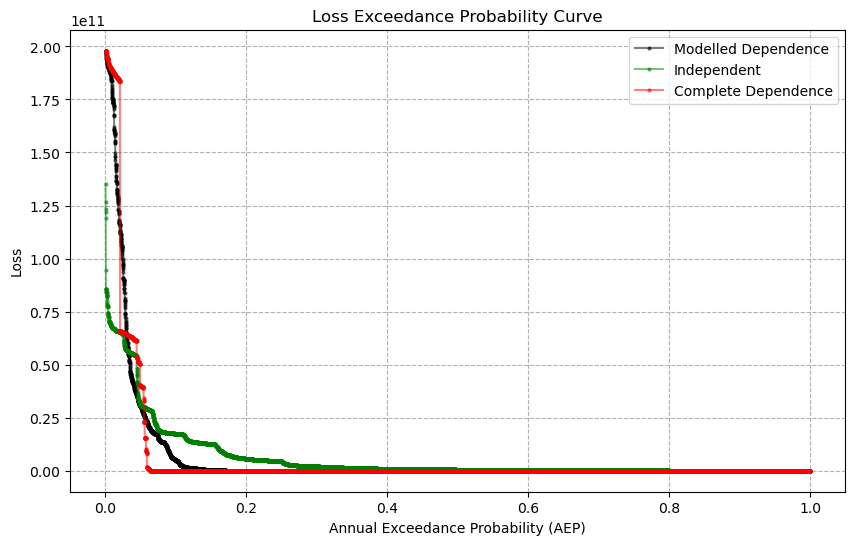

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
# Plot loss-probability curve
flat_dependent_losses = dependent_losses.values.flatten()  # Flatten to get a single array of losses
flat_independent_losses = independent_losses.values.flatten()  # Flatten to get a single array of losses
flat_complete_dependent_losses = complete_dependent_losses.values.flatten()  # Flatten to get a single array of losses
sorted_dependent_losses = np.sort(flat_dependent_losses)[::-1]  # Sort losses from highest to lowest
sorted_independent_losses = np.sort(flat_independent_losses)[::-1]  # Sort losses from highest to lowest
sorted_complete_dependent_losses = np.sort(flat_complete_dependent_losses)[::-1]  # Sort losses from highest to lowest
aeps = np.arange(1, len(sorted_dependent_losses) + 1) / len(sorted_dependent_losses)  # Calculate AEPs
plt.figure(figsize=(10, 6))
# plt.semilogx(aeps, sorted_losses, marker='o', linestyle='-', markersize=2, label='Baseline', alpha=0.5, color='black')
plt.plot(aeps, sorted_dependent_losses, marker='o', linestyle='-', markersize=2, label='Modelled Dependence', alpha=0.5, color='black')
plt.plot(aeps, sorted_independent_losses, marker='o', linestyle='-', markersize=2, label='Independent', alpha=0.5, color='green')
plt.plot(aeps, sorted_complete_dependent_losses, marker='o', linestyle='-', markersize=2, label='Complete Dependence', alpha=0.5, color='red')
plt.xlabel('Annual Exceedance Probability (AEP)')
plt.ylabel('Loss')
plt.title('Loss Exceedance Probability Curve')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()
plt.savefig('loss_exceedance_probability_curve_vine.png')

## Uncertainty

In [48]:
# Load risk data
risk_data = pd.read_csv(r"D:\projects\sovereign-risk\Thailand\test\copulas\risk_basin_zonal_sum_u.csv")
# Add columne for annual exceedance probability
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
# Add entries converting SD to variance (this will help for summation)
sd_rows = risk_data[risk_data['statistic']=='sd']
variance_rows = sd_rows.copy() # create new rows for variance
variance_rows['statistic'] = 'variance'
variance_rows['damages'] = variance_rows['damages'] ** 2
risk_data = pd.concat([risk_data, variance_rows], ignore_index=True)
risk_data.head()

,Unnamed: 0,FID,GID_1,NAME,HB_L4,HB_L5,HB_L6,HB_L7,Pr_L,Add_Pr,New_Pr_L,damages,model,RP,statistic,AEP,Pr_L_AEP
0,0,0,THA.62_1,Si Sa Ket,4.041145e+09,4.051145e+09,4.061140e+09,4.071125e+09,16.387501,83.612499,100.0,0.000000e+00,GIRI,2,mean,0.5,0.061022
1,1,1,THA.62_1,Si Sa Ket,4.041145e+09,4.051145e+09,4.061140e+09,4.071125e+09,16.387501,83.612499,100.0,0.000000e+00,GIRI,2,mean,0.5,0.061022
2,2,2,THA.62_1,Si Sa Ket,4.041145e+09,4.051145e+09,4.061131e+09,4.071121e+09,16.387501,83.612499,100.0,0.000000e+00,GIRI,2,mean,0.5,0.061022
3,3,3,THA.62_1,Si Sa Ket,4.041109e+09,4.051109e+09,4.061109e+09,4.071109e+09,16.387501,83.612499,100.0,1.106698e+05,GIRI,2,mean,0.5,0.061022
4,4,4,THA.62_1,Si Sa Ket,4.041109e+09,4.051110e+09,4.061110e+09,4.071111e+09,16.387501,83.612499,100.0,2.922638e+06,GIRI,2,mean,0.5,0.061022


In [13]:
def basin_loss_curve_u(loss_df, basin_id, basin_col, model_val, r_sample, rps):
    '''
    Function for extracting loss curves from each basin from the risk results dataframe.
    Extracting these loss curves at the beginning of the Monte Carlo simulation significantly reduces 
    compuatation times. 
    '''
    losses = {} # initialize empty dictionary to store losses and protection level
    mean_basin_df = loss_df[(loss_df[basin_col]==basin_id) & (loss_df['model']==model_val) & (loss_df['statistic']=='mean')]
    variance_basin_df = loss_df[(loss_df[basin_col]==basin_id) & (loss_df['model']==model_val) & (loss_df['statistic']=='variance')]
    mean_grouped_basin_df = mean_basin_df.groupby([basin_col, 'RP', 'Pr_L_AEP']).agg({'damages':'sum'}).reset_index()
    variance_grouped_basin_df = variance_basin_df.groupby([basin_col, 'RP', 'Pr_L_AEP']).agg({'damages':'sum'}).reset_index()
    # Convert to standard deviation
    # # Pull unique protection levels from the grouped dataframe
    unique_protection_levels = mean_grouped_basin_df['Pr_L_AEP'].unique()
    if len(unique_protection_levels) == 0:
        unique_protection_levels = [1]
    for i in unique_protection_levels:
        mean_losses = [mean_grouped_basin_df.loc[(mean_grouped_basin_df['RP'] == rp) & (mean_grouped_basin_df['Pr_L_AEP']==i), 'damages'].sum() for rp in rps]
        variance_losses = [variance_grouped_basin_df.loc[(mean_grouped_basin_df['RP'] == rp) & (mean_grouped_basin_df['Pr_L_AEP']==i), 'damages'].sum() for rp in rps]
        std_losses = [math.sqrt(x) for x in variance_losses]
        losses[i] = []
        # Find the new loss curve based on the random number
        for mean_loss, std_loss in zip(mean_losses, std_losses):
            sampled_loss =  max(0, mean_loss + (r_sample * std_loss))
            losses[i].append(sampled_loss)
    return losses

def interpolate_damages(RPs, losses, sim_aep, protection_level=0.5):
    '''
    Function to interpolate damages between given an annual exceedance probability and 
    a depth-damage curve
    '''
    aeps = [1/i for i in RPs]
    # Ensure AEPs are in ascending order for np.interp
    aeps.sort() 
    losses = losses[::-1]

    # Interpolate based off simulated AEP
    if sim_aep >= protection_level: 
        return 0 
    else:
        interpolated_value = np.interp(sim_aep, aeps, losses)
        return interpolated_value

In [74]:
def monte_carlo_dependence_simulation_u(
        model,
        v_sample,
        basin_ids,
        loss_df, 
        rps, 
        basin_col, 
        protection_level, 
        num_years, 
        num_simulations=1000):
    '''
    Perform Monte Carlo simulations of yearly losses assuming independence between basins
    :param model: string of flood model to use
    :v_sample: randomly sampled gaussian number - for choosing vulnerability curve
    :param loss_df: dataframe with losses from risk analysis
    :param rps: list of return periods to consider. 
    :param basin_col: name of column for basins (e.g. 'HB_L6')
    :param protection_level: what is the baseline protection level (e.g. 0.5 or 1 in 2 years)
    :param num_years: Number of years to simulate
    :param num__simulations: Number of simulations (default is 10,000).
    :return: Dataframe of simulated national losses for each year.
    '''
    # Debug for uncertainty
    # np.random.seed(0)

    # To speed up the Monte-Carlo simulation we are going to pre-compute some variables
    # precompute loss-probability curves for each basin
    basin_loss_curves = {basin_id: basin_loss_curve_u(loss_df, basin_id, basin_col, model, v_sample, rps) for basin_id in basin_ids}
    national_losses_per_year = np.zeros((num_simulations, num_years))

    random_numbers = vine_random_numbers.sample(n=num_simulations*num_years, replace=True).reset_index(drop=True)
    i = 0
    # for sim in tqdm(range(num_simulations)):
    for sim in range(num_simulations):
        for year in range(num_years):
            random_ns = random_numbers.loc[i]
            i += 1
            yearly_loss_values = []
            for _, basin_id in enumerate(basin_ids):
                loss_curves = basin_loss_curves[basin_id]
                r = 1-random_ns[str(basin_id)]
                for Pr_L in loss_curves:
                    if Pr_L > r:
                        yearly_loss_values.append(interpolate_damages(rps, loss_curves[Pr_L], r, protection_level))
            national_losses_per_year[sim, year] = sum(yearly_loss_values)
    return pd.DataFrame(national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])

In [77]:
# Uncertainty simulation
model_name_and_rps = {'GIRI': [2, 5, 10, 25, 50, 100, 200, 500, 1000],
                      'JRC': [2, 10, 20, 50, 100, 200, 500],
                      'WRI': [2, 5, 10, 25, 50, 100, 250, 500, 1000]}   
num_uncertainty_simulations = 1000
all_losses = []

np.random.seed(0)
random.seed(0)

for _ in tqdm(range(num_uncertainty_simulations)):
    selected_model = random.choice(list(model_name_and_rps.keys()))
    random_gaussian_number = np.random.normal(loc=0, scale=1)
    losses = monte_carlo_dependence_simulation_u(selected_model, random_gaussian_number, basin_ids, risk_data, model_name_and_rps[selected_model],
                                                 'HB_L6', 0.5, 10)
    all_losses.append(losses)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [4:37:36<00:00, 16.66s/it]


In [69]:
all_losses

[           Year_1        Year_2        Year_3        Year_4        Year_5  \
 0    0.000000e+00  1.014549e+09  1.508372e+11  0.000000e+00  0.000000e+00   
 1    0.000000e+00  0.000000e+00  7.848525e+10  0.000000e+00  0.000000e+00   
 2    5.478099e+06  8.024898e+08  1.122948e+10  0.000000e+00  0.000000e+00   
 3    1.005609e+10  0.000000e+00  0.000000e+00  4.893388e+08  0.000000e+00   
 4    1.296465e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
 ..            ...           ...           ...           ...           ...   
 995  0.000000e+00  2.718427e+10  0.000000e+00  0.000000e+00  0.000000e+00   
 996  0.000000e+00  0.000000e+00  0.000000e+00  3.967887e+05  0.000000e+00   
 997  1.238200e+07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
 998  1.383353e+10  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
 999  1.713394e+11  0.000000e+00  0.000000e+00  0.000000e+00  8.012431e+07   
 
            Year_6        Year_7        Year_8        Year_9  

In [49]:
troubleshoot_dependent_losses = monte_carlo_dependence_simulation_u('GIRI', 0, basin_ids, risk_data, model_name_and_rps['GIRI'],'HB_L6', 0.5, 10)

In [64]:
old_all_losses = all_losses.copy()

(1000, 10000)


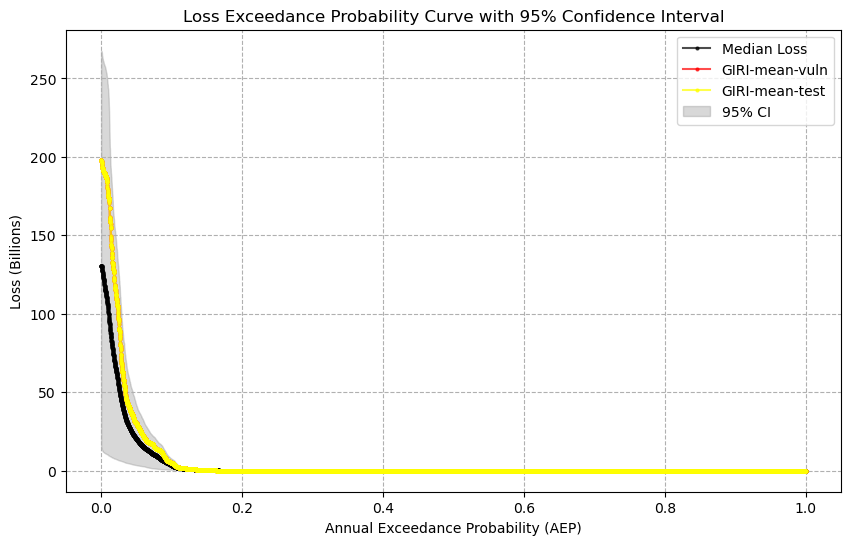

<Figure size 640x480 with 0 Axes>

In [78]:
import matplotlib.pyplot as plt
# Flatten all losses from the uncertainty simulations
all_losses_flat = np.array([loss.values.flatten() for loss in all_losses])
sorted_losses_all = np.sort(all_losses_flat, axis=1)[:, ::-1]  # Sort each simulation from highest to lowest
sorted_losses_all = sorted_losses_all / 1e9  # Convert losses to billions for better visualization
aeps = np.arange(1, sorted_losses_all.shape[1] + 1) / sorted_losses_all.shape[1]  # Calculate AEPs

print(sorted_losses_all.shape)

# Calculate percentiles
loss_p2_5 = np.percentile(sorted_losses_all, 2.5, axis=0)
loss_p50 = np.percentile(sorted_losses_all, 50, axis=0)  # Median
loss_p97_5 = np.percentile(sorted_losses_all, 97.5, axis=0)

# Plot the loss exceedance probability curve with confidence intervals
plt.figure(figsize=(10, 6))

flat_test_losses = troubleshoot_dependent_losses.values.flatten()
sorted_test_losses = np.sort(flat_test_losses)[::-1]
# Plot the median loss exceedance curve
plt.plot(aeps, loss_p50, label='Median Loss', marker='o', linestyle='-', markersize=2, color='black', alpha=0.7)
plt.plot(aeps, sorted_dependent_losses / 1e9, label='GIRI-mean-vuln', marker='o', linestyle='-', markersize=2, color='red', alpha=0.7)
plt.plot(aeps, sorted_test_losses / 1e9, label='GIRI-mean-test', marker='o', linestyle='-', markersize=2, color='yellow', alpha=0.7)

# Plot the 95% confidence interval (shaded region)
plt.fill_between(aeps, loss_p2_5, loss_p97_5, color='gray', alpha=0.3, label='95% CI')

plt.xlabel('Annual Exceedance Probability (AEP)')
plt.ylabel('Loss (Billions)')
plt.title('Loss Exceedance Probability Curve with 95% Confidence Interval')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

# Save the figure
plt.savefig('loss_exceedance_probability_curve_with_CI.png')

In [70]:
print(all_losses_flat.shape)
unique_losses = np.unique(all_losses_flat, axis=0)
print(f"Number of unique loss simulations: {unique_losses.shape[0]}")

(1000, 10000)
Number of unique loss simulations: 4


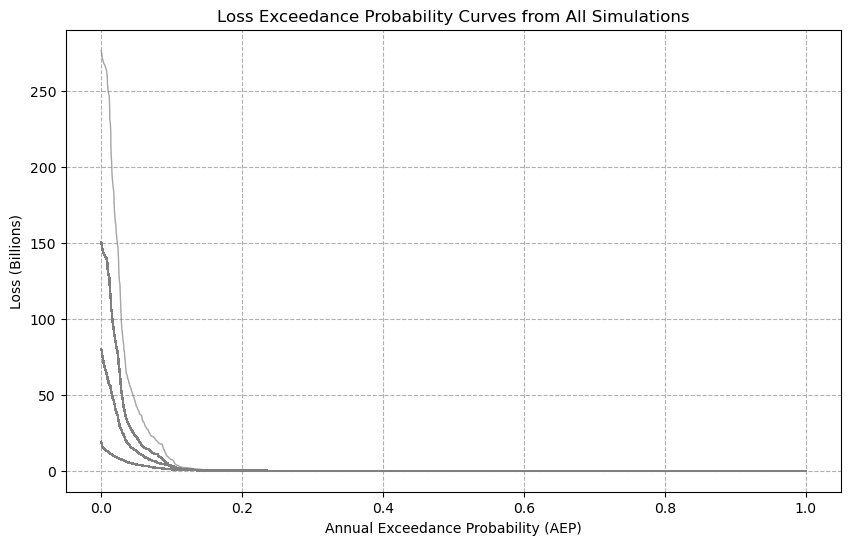

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten all losses from the uncertainty simulations
all_losses_flat = np.array([loss.values.flatten() for loss in all_losses])
sorted_losses_all = np.sort(all_losses_flat, axis=1)[:, ::-1]  # Sort each simulation from highest to lowest
sorted_losses_all = sorted_losses_all / 1e9  # Convert losses to billions

# Calculate AEPs (Annual Exceedance Probabilities)
aeps = np.arange(1, sorted_losses_all.shape[1] + 1) / sorted_losses_all.shape[1]

# Plot each simulation
plt.figure(figsize=(10, 6))

for i in range(sorted_losses_all.shape[0]):  # Loop over all simulations
    plt.plot(aeps, sorted_losses_all[i], color='gray', alpha=0.7, lw=1)  # Plot with lower opacity and thin lines

# Add labels and grid
plt.xlabel('Annual Exceedance Probability (AEP)')
plt.ylabel('Loss (Billions)')
plt.title('Loss Exceedance Probability Curves from All Simulations')
plt.grid(True, which="both", ls="--")
plt.show()


In [54]:
# 100-year flood info

index_100yr_flood = np.abs(aeps - 0.01).argmin()  # Find closest AEP to 0.01 (100-year flood)

# Extract the losses for the 100-year flood (1% AEP) across all simulations
losses_100yr_flood = sorted_losses_all[:, index_100yr_flood]

# Calculate the 2.5th, 50th (median), and 97.5th percentiles for the 100-year flood losses
loss_p2_5 = np.percentile(losses_100yr_flood, 2.5)
loss_p50 = np.percentile(losses_100yr_flood, 50)  # Median
loss_p97_5 = np.percentile(losses_100yr_flood, 97.5)

# Print the results
print(f"100-year flood loss estimate (95% CI):")
print(f"Lower bound (2.5th percentile): {loss_p2_5:.2f} billion")
print(f"Median (50th percentile): {loss_p50:.2f} billion")
print(f"Upper bound (97.5th percentile): {loss_p97_5:.2f} billion")

100-year flood loss estimate (95% CI):
Lower bound (2.5th percentile): 12.41 billion
Median (50th percentile): 59.27 billion
Upper bound (97.5th percentile): 130.50 billion


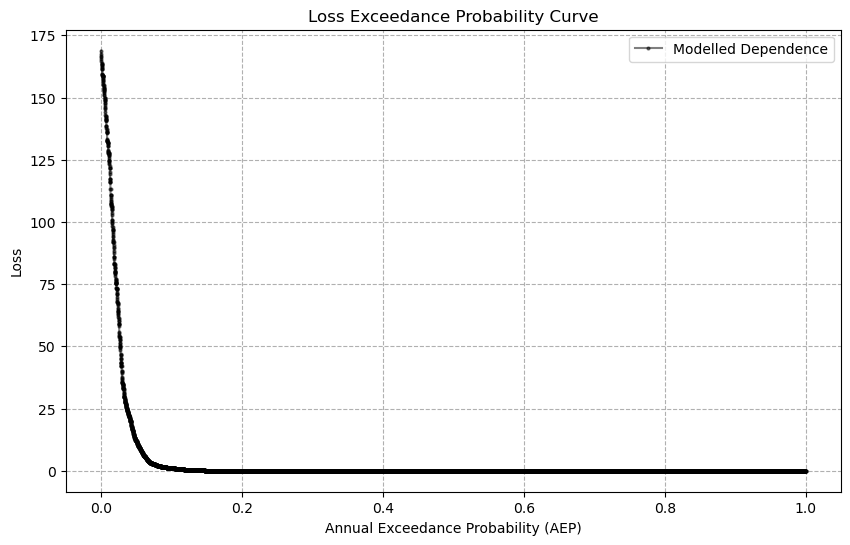

<Figure size 640x480 with 0 Axes>

In [98]:
flat_losses = losses.values.flatten()  # Flatten to get a single array of losses
sorted_losses = np.sort(flat_losses)[::-1]  # Sort losses from highest to lowest
sorted_losses = sorted_losses/1000000000
aeps = np.arange(1, len(sorted_losses) + 1) / len(sorted_losses)  # Calculate AEPs
plt.figure(figsize=(10, 6))
# plt.semilogx(aeps, sorted_losses, marker='o', linestyle='-', markersize=2, label='Baseline', alpha=0.5, color='black')
plt.plot(aeps, sorted_losses, marker='o', linestyle='-', markersize=2, label='Modelled Dependence', alpha=0.5, color='black')
plt.xlabel('Annual Exceedance Probability (AEP)')
plt.ylabel('Loss')
plt.title('Loss Exceedance Probability Curve')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()
plt.savefig('loss_exceedance_probability_curve_vine.png')

In [1]:
all_losses

NameError: name 'all_losses' is not defined